# **COVID-19 Prediction Project for National Policy Making - Sharon Marfatia**

In [ ]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_classif

# **1. Picking the problem and explain the prediction problem**

This dataset is based COVID-19 patients data for population count for each country that comes from the Population Reference Bureau. The current version of data include COVID-19 data from the week of 02/06/2021. It includes data for different food group supply quantities, nutrition values, obesity, and undernourished percentages that are obtained from Food and Agriculture Organization of the United Nations FAO website. Data for COVID-19 confirmed, deaths, recovered and active cases are obtained from Johns Hopkins Center for Systems Science and Engineering.

**The USDA Center for Nutrition Policy and Promotion recommends a very simple daily diet intake guideline: 30% grains, 40% vegetables, 10% fruits, and 20% protein, but are we really eating in the healthy eating style recommended by these food divisions and balances?**

*We will test this proposal.*

In [ ]:
data = pd.read_csv('covid_data/Fat_Supply_Quantity_Data.csv')
data.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.142134,0.006186,0.123374,0.012574,38928000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,2.967301,0.050951,1.792636,1.123714,2838000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.244897,0.006558,0.167572,0.070767,44357000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.061687,0.001461,0.056808,0.003419,32522000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.293878,0.007143,0.190816,0.095918,98000.0,%


# **Feature Enginnering:**

In [ ]:
# Added columns: Total_num_cases, Total_num_deaths, Total_num_recovered, Total_num_active at time of data recording
# Added because if there are more number of cases in a region it may increase chances of one gettting the virus since it is contagious

for index, row in data.iterrows():
  data.loc[index, 'Total_num_cases'] = row['Confirmed'] * row['Population']
  data.loc[index, 'Total_num_deaths'] = row['Deaths'] * row['Population']
  data.loc[index, 'Total_num_active'] = row['Active'] * row['Population']
  data.loc[index, 'Total_num_recovered'] = row['Recovered'] * row['Population']

data.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,0.142134,0.006186,0.123374,0.012574,38928000.0,%,5533000.0,240800.0,489500.0,4802700.0
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,2.967301,0.050951,1.792636,1.123714,2838000.0,%,8421200.0,144600.0,3189100.0,5087500.0
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,0.244897,0.006558,0.167572,0.070767,44357000.0,%,10862900.0,290900.0,3139000.0,7433000.0
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,0.061687,0.001461,0.056808,0.003419,32522000.0,%,2006200.0,47500.0,111200.0,1847500.0
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,0.293878,0.007143,0.190816,0.095918,98000.0,%,28800.0,700.0,9400.0,18700.0


# **2. Data splitting**

In [ ]:
data.shape

(170, 36)

In [ ]:
# Dropping rows in the DataFrame that has NaN value in the Deaths column
data = data.dropna(subset=['Deaths'])

In [ ]:
data.shape

(164, 36)

In [ ]:
# Splitting the data
train_df, test_df = train_test_split(data, test_size = 0.3, random_state = 123)

# **3. EDA**

In [ ]:
train_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
159,United Kingdom,0.0,25.8633,4.2615,0.0,1.4678,1.0778,0.5176,0.4219,12.5789,...,5.868483,0.167220,0.015161,5.686102,67160000.0,%,394127300.0,11230500.0,381878600.0,1018200.0
96,Mali,0.0,17.4631,1.2195,0.0,12.0873,0.1327,0.4065,0.2987,5.6745,...,0.040294,0.001669,0.029895,0.008730,20251000.0,%,816000.0,33800.0,176800.0,605400.0
127,Rwanda,0.0,11.0727,1.0364,0.0,4.8545,0.1636,0.6364,9.6727,5.2182,...,0.126135,0.001675,0.093013,0.031447,12952000.0,%,1633700.0,21700.0,407300.0,1204700.0
5,Argentina,0.0,30.3572,3.3076,0.0,1.3316,1.5706,0.1664,0.2091,19.2693,...,4.356147,0.108227,3.905192,0.342729,45377000.0,%,197668900.0,4911000.0,15552000.0,177205900.0
16,Benin,0.0,6.1742,0.4816,0.0,4.6952,0.2064,0.8599,0.1978,3.2849,...,0.034344,0.000450,0.029183,0.004710,12209000.0,%,419300.0,5500.0,57500.0,356300.0


In [ ]:
# Part 1:
train_df.sort_index()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
1,Albania,0.0000,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,2.967301,0.050951,1.792636,1.123714,2838000.0,%,8421200.0,144600.0,3189100.0,5087500.0
2,Algeria,0.0000,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,0.244897,0.006558,0.167572,0.070767,44357000.0,%,10862900.0,290900.0,3139000.0,7433000.0
3,Angola,0.0000,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,0.061687,0.001461,0.056808,0.003419,32522000.0,%,2006200.0,47500.0,111200.0,1847500.0
5,Argentina,0.0000,30.3572,3.3076,0.0,1.3316,1.5706,0.1664,0.2091,19.2693,...,4.356147,0.108227,3.905192,0.342729,45377000.0,%,197668900.0,4911000.0,15552000.0,177205900.0
6,Armenia,0.0000,29.6642,6.2619,0.0,2.5068,1.6196,0.2218,0.5468,10.8165,...,5.681225,0.105345,5.398410,0.177470,2956000.0,%,16793700.0,311400.0,524600.0,15957700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Vanuatu,0.0000,14.9179,1.9531,0.0,4.1249,0.3509,1.4343,0.3052,9.9334,...,0.000312,0.000000,0.000312,0.000000,321000.0,%,100.0,0.0,0.0,100.0
165,Venezuela (Bolivarian Republic of),0.0000,16.3261,2.2673,0.0,2.5449,0.6555,0.5707,0.9640,7.0949,...,0.452585,0.004287,0.424399,0.023899,28645000.0,%,12964300.0,122800.0,684600.0,12156900.0
166,Vietnam,0.0000,33.2484,3.8238,0.0,3.7155,0.7839,1.1217,0.4079,26.4292,...,0.002063,0.000036,0.001526,0.000501,96209000.0,%,198500.0,3500.0,48200.0,146800.0
167,Yemen,0.0000,12.5401,2.0131,0.0,11.5271,0.5514,0.3847,0.2564,8.0010,...,0.007131,0.002062,0.004788,0.000282,29826000.0,%,212700.0,61500.0,8400.0,142800.0


In [ ]:
train_df.isna().sum()

Country                         0
Alcoholic Beverages             0
Animal Products                 0
Animal fats                     0
Aquatic Products, Other         0
Cereals - Excluding Beer        0
Eggs                            0
Fish, Seafood                   0
Fruits - Excluding Wine         0
Meat                            0
Miscellaneous                   0
Milk - Excluding Butter         0
Offals                          0
Oilcrops                        0
Pulses                          0
Spices                          0
Starchy Roots                   0
Stimulants                      0
Sugar Crops                     0
Sugar & Sweeteners              0
Treenuts                        0
Vegetal Products                0
Vegetable Oils                  0
Vegetables                      0
Obesity                         1
Undernourished                  5
Confirmed                       0
Deaths                          0
Recovered                       0
Active        

In [ ]:
train_df.isna().sum()

Country                         0
Alcoholic Beverages             0
Animal Products                 0
Animal fats                     0
Aquatic Products, Other         0
Cereals - Excluding Beer        0
Eggs                            0
Fish, Seafood                   0
Fruits - Excluding Wine         0
Meat                            0
Miscellaneous                   0
Milk - Excluding Butter         0
Offals                          0
Oilcrops                        0
Pulses                          0
Spices                          0
Starchy Roots                   0
Stimulants                      0
Sugar Crops                     0
Sugar & Sweeteners              0
Treenuts                        0
Vegetal Products                0
Vegetable Oils                  0
Vegetables                      0
Obesity                         1
Undernourished                  5
Confirmed                       0
Deaths                          0
Recovered                       0
Active        

In [ ]:
summary = train_df.describe(include="all")
summary

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
count,114,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,113.000000,1.140000e+02,114,1.140000e+02,1.140000e+02,1.130000e+02,1.140000e+02
unique,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
top,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,%,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,114,NaN,NaN,NaN,NaN
mean,NaN,0.000687,20.840037,4.197701,0.000223,4.521948,0.963941,0.861879,0.545424,9.417241,...,1.988977,0.040503,1.458996,0.492519,5.127686e+07,NaN,4.828876e+07,1.195967e+06,1.314060e+07,3.401858e+07
std,NaN,0.007333,8.445222,3.303051,0.001244,3.235979,0.647483,0.957719,0.940166,4.799228,...,2.348567,0.049951,1.958076,1.190950,1.863658e+08,NaN,1.254472e+08,2.839232e+06,5.263664e+07,1.093308e+08
min,NaN,0.000000,5.018200,0.034800,0.000000,1.078000,0.058000,0.017400,0.042000,0.906100,...,0.000312,0.000000,0.000000,0.000000,5.400000e+04,NaN,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,0.000000,13.853050,1.633200,0.000000,1.985125,0.438275,0.342125,0.254675,6.486075,...,0.127345,0.001671,0.095044,0.009929,2.867500e+06,NaN,1.160200e+06,1.662500e+04,9.200000e+04,7.624250e+05
50%,NaN,0.000000,20.426350,3.367150,0.000000,3.645750,0.898300,0.615100,0.374550,9.172700,...,1.234635,0.012576,0.475402,0.072239,1.031600e+07,NaN,7.518250e+06,9.390000e+04,6.846000e+05,5.214250e+06
75%,NaN,0.000000,27.208050,6.387250,0.000000,5.722775,1.282275,1.072475,0.575950,11.889000,...,3.202011,0.069680,2.417560,0.372101,3.274850e+07,NaN,2.604937e+07,6.267500e+05,3.612900e+06,1.991505e+07


In [ ]:
# Country/countries with maximum percentage of population deaths
max = train_df['Deaths'].max()
train_df[train_df['Deaths'] == max]

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
14,Belgium,0.0,26.7378,12.6234,0.0,1.3531,1.1703,0.6188,0.2373,5.6817,...,6.286322,0.185428,0.0,6.100894,11515000.0,%,72387000.0,2135200.0,70251800.0,0.0


In [ ]:
# Country/countries with minimum percentage of population deaths
min = train_df['Deaths'].min()
train_df[train_df['Deaths'] == min]

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
139,Solomon Islands,0.0,13.6649,3.4726,0.0000,3.0802,0.2943,2.5505,0.5690,6.5431,...,0.002378,0.0,0.001399,0.000979,715000.0,%,1700.0,0.0,700.0,1000.0
150,Timor-Leste,0.0,17.8988,2.0345,0.0000,10.2168,0.2446,0.7893,1.3007,14.5525,...,0.006070,0.0,0.004628,0.001442,1318000.0,%,8000.0,0.0,1900.0,6100.0
164,Vanuatu,0.0,14.9179,1.9531,0.0000,4.1249,0.3509,1.4343,0.3052,9.9334,...,0.000312,0.0,0.000312,0.000000,321000.0,%,100.0,0.0,0.0,100.0
128,Saint Kitts and Nevis,0.0,24.3013,4.7370,0.0000,2.0602,0.5600,0.7296,0.3596,14.3547,...,0.074074,0.0,0.066667,0.007407,54000.0,%,4000.0,0.0,400.0,3600.0
131,Samoa,0.0,21.6806,4.7780,0.0036,1.5771,0.2227,1.8968,0.6287,13.2418,...,0.001000,0.0,0.001000,0.000000,200000.0,%,200.0,0.0,0.0,200.0


In [ ]:
# Country/countries with minimum number of population deaths
min = train_df['Total_num_deaths'].min()
train_df[train_df['Total_num_deaths'] == min]

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
139,Solomon Islands,0.0,13.6649,3.4726,0.0000,3.0802,0.2943,2.5505,0.5690,6.5431,...,0.002378,0.0,0.001399,0.000979,715000.0,%,1700.0,0.0,700.0,1000.0
150,Timor-Leste,0.0,17.8988,2.0345,0.0000,10.2168,0.2446,0.7893,1.3007,14.5525,...,0.006070,0.0,0.004628,0.001442,1318000.0,%,8000.0,0.0,1900.0,6100.0
164,Vanuatu,0.0,14.9179,1.9531,0.0000,4.1249,0.3509,1.4343,0.3052,9.9334,...,0.000312,0.0,0.000312,0.000000,321000.0,%,100.0,0.0,0.0,100.0
128,Saint Kitts and Nevis,0.0,24.3013,4.7370,0.0000,2.0602,0.5600,0.7296,0.3596,14.3547,...,0.074074,0.0,0.066667,0.007407,54000.0,%,4000.0,0.0,400.0,3600.0
131,Samoa,0.0,21.6806,4.7780,0.0036,1.5771,0.2227,1.8968,0.6287,13.2418,...,0.001000,0.0,0.001000,0.000000,200000.0,%,200.0,0.0,0.0,200.0


In [ ]:
# Country/countries with maximum number of population deaths
max = train_df['Total_num_deaths'].max()
train_df[train_df['Total_num_deaths'] == max]

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Total_num_cases,Total_num_deaths,Total_num_active,Total_num_recovered
100,Mexico,0.0,23.7741,3.2525,0.0,6.4604,2.2807,0.4661,0.5305,13.2133,...,1.507199,0.129731,1.159805,0.217663,127792000.0,%,1.926080e+08,16578600.0,27815600.0,148213800.0


# **Data Visualization**

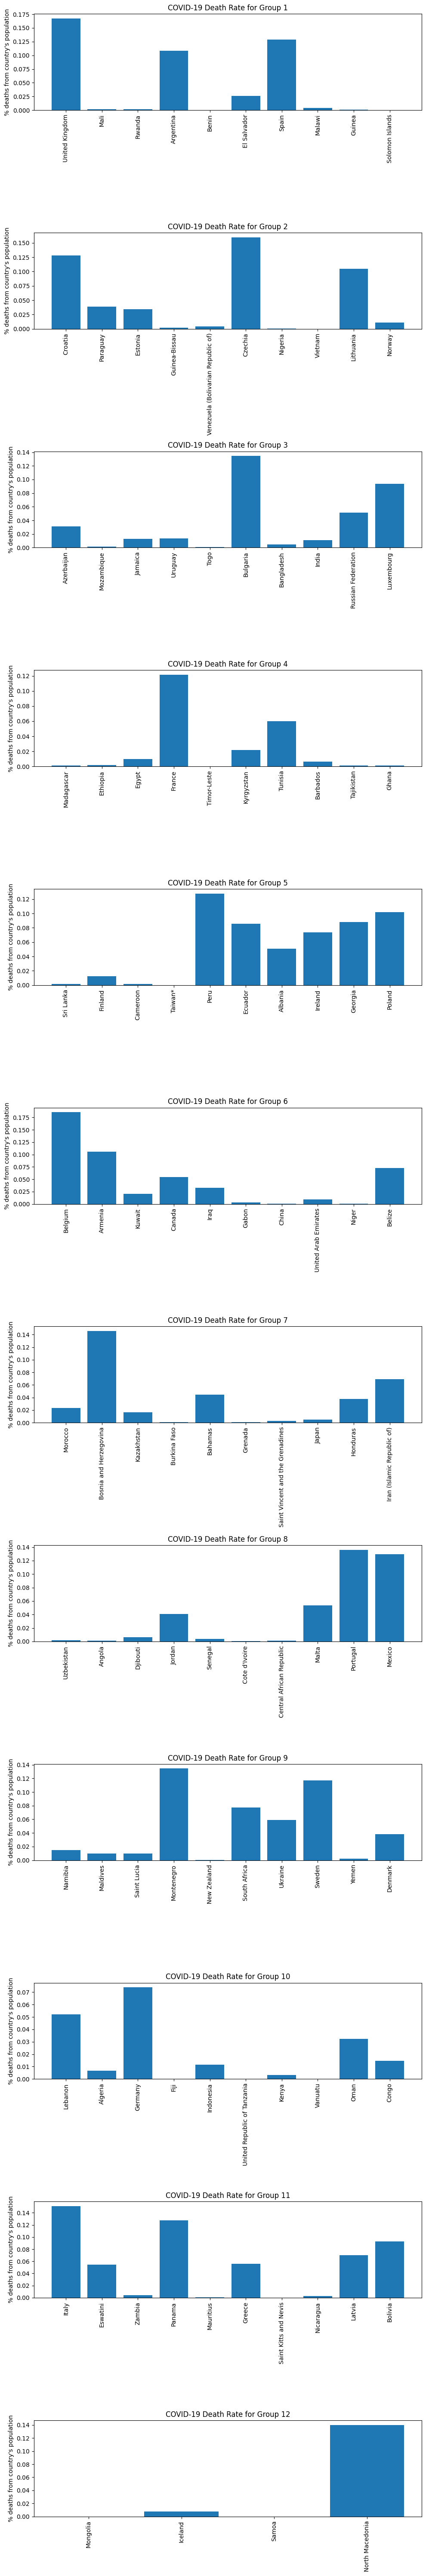

In [ ]:
# Coutries with the largest percentage of deaths due to COVID-19

# Example data (replace this with your actual data)
countries = train_df['Country'].tolist()
deaths_percentage = train_df['Deaths'].tolist()

# Split data into groups of 10 countries
group_size = 10
num_groups = int(np.ceil(len(countries) / group_size))

# Create subplots to display multiple bar plots
fig, axes = plt.subplots(num_groups, 1, figsize=(10, 5*num_groups))

for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    countries_group = countries[start_idx:end_idx]
    deaths_percentage_group = deaths_percentage[start_idx:end_idx]

    # Create the bar plot for the current group
    axes[i].bar(range(len(countries_group)), deaths_percentage_group)

    # Set the tick positions and labels for x-axis
    axes[i].set_xticks(range(len(countries_group)))
    axes[i].set_xticklabels(countries_group, rotation=90)

    # Add labels and title for each subplot
    axes[i].set_ylabel("% deaths from country's population")
    axes[i].set_title(f"COVID-19 Death Rate for Group {i+1}")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# **Preprocessing and transformations**

In [ ]:
# creating list of features
numeric_features = ["Alcoholic Beverages", "Animal Products", "Animal fats",
                    "Aquatic Products, Other", "Cereals - Excluding Beer",
                    "Eggs", "Fish, Seafood", "Fruits - Excluding Wine", "Meat",
                    "Miscellaneous", "Milk - Excluding Butter", "Offals",
                    "Oilcrops", "Pulses", "Spices", "Starchy Roots",
                    "Stimulants", "Sugar Crops", "Sugar & Sweeteners",
                    "Treenuts", "Vegetal Products", "Vegetable Oils",
                    "Vegetables", "Obesity", "Confirmed", "Recovered",
                    "Active", "Population"]

# We can drop ID becuase that is not helpful for making predictions on unseen, new data
drop_features = ["Country", "Undernourished", "Unit (all except Population)",
                 "Total_num_cases", "Total_num_deaths", "Total_num_active",
                 "Total_num_recovered"]

target_features = ['Deaths']
train_df.columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Miscellaneous',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'Population', 'Unit (all except Population)',
       'Total_num_cases', 'Total_num_deaths', 'Total_num_active',
       'Total_num_recovered'],
      dtype='object')

In [ ]:
# Splitting data into X_train, y_train, X_test, and y_test
X_train = train_df.drop(columns=["Deaths"])
y_train = train_df["Deaths"]
X_test = test_df.drop(columns = ["Deaths"])
y_test = test_df["Deaths"]

print(X_test.shape)

(50, 35)


In [ ]:
# Defining transformers
# Numeric transformer:
numeric_transformer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                                    StandardScaler())

In [ ]:
# Part 2: Column Transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    ("drop", drop_features),
)

# **Baseline model**
I have tried `scikit-learn`'s baseline model and reported the results.

In [ ]:
dummy = DummyRegressor(strategy="mean")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
dummy_df = pd.DataFrame(scores)

In [ ]:
dummy_df

,fit_time,score_time,test_score,train_score
0,0.013706,0.009883,-0.001252,0.0
1,0.010146,0.000632,-0.041000,0.0
2,0.001203,0.000627,-0.025300,0.0
3,0.012257,0.000705,-0.001696,0.0
4,0.014088,0.000611,-0.003061,0.0


In [ ]:
cross_val_score(dummy, X_train, y_train)

array([-0.00125211, -0.04099982, -0.02529978, -0.00169598, -0.00306073])

# **Linear models & Hyperparameter Optimization**

In [ ]:
all_columns = X_train.columns
all_columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Miscellaneous',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Obesity', 'Undernourished', 'Confirmed', 'Recovered', 'Active',
       'Population', 'Unit (all except Population)', 'Total_num_cases',
       'Total_num_deaths', 'Total_num_active', 'Total_num_recovered'],
      dtype='object')

In [ ]:
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train))
n_new_cols = transformed_df.shape[1] - X_train.shape[1]
transformed_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.094072,0.597431,0.019400,-0.179912,-0.947977,0.176625,-0.361065,-0.131965,0.661693,0.273733,...,-0.129444,-0.087266,-0.597875,0.027379,-0.521058,1.114726,1.659154,-0.740630,4.399636,0.085602
1,-0.094072,-0.401629,-0.905632,-0.179912,2.348208,-1.289471,-0.477582,-0.263584,-0.783306,-0.425991,...,-0.129444,0.618833,0.401610,-0.579048,0.334286,-1.266568,-0.833396,-0.733072,-0.409832,-0.167213
2,-0.094072,-1.161658,-0.961311,-0.179912,0.103221,-1.241538,-0.236473,9.751020,-0.878804,-0.514280,...,-0.129444,-0.849189,1.159481,-0.387236,-0.309374,-1.511076,-0.796684,-0.700695,-0.390588,-0.206551
3,-0.094072,1.131904,-0.270668,-0.179912,-0.990252,0.941086,-0.729389,-0.359308,2.061906,-0.754110,...,-0.129444,-0.717262,-1.131686,-0.123783,-0.647157,1.008419,1.012371,1.254801,-0.126892,-0.031797
4,-0.094072,-1.744251,-1.130018,-0.179912,0.053776,-1.175144,-0.002075,-0.371380,-1.283418,-0.414131,...,-0.129444,1.267213,1.744755,0.979697,0.230977,-1.149629,-0.835941,-0.733437,-0.413238,-0.210555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-0.094072,1.139100,-0.008880,-0.179912,-0.556327,0.858559,-0.711874,-0.005046,2.455009,-0.179572,...,-0.129444,-0.043476,-1.139654,-0.848396,-0.626393,-0.033398,-0.015623,-0.010455,-0.060251,-0.213660
110,-0.094072,1.910273,0.400665,-0.179912,-0.551702,-0.575426,-0.870866,-0.537827,2.428786,-0.062292,...,-0.129444,-0.781777,-1.910310,-1.450329,-0.880616,0.062279,-0.824887,-0.726292,-0.402810,-0.258242
111,-0.094072,1.617507,0.885167,-0.179912,-0.068735,-0.100586,0.865561,-0.051199,0.876003,0.825869,...,-0.129444,-0.311787,-1.617186,-1.569653,-0.748441,0.434357,-0.150898,0.082226,-0.409631,-0.274372
112,-0.094072,0.099971,0.176461,2.727012,-0.914051,-1.149858,1.085381,0.088967,0.800430,0.145912,...,-0.129444,-0.801387,-0.099993,-1.434075,-1.379947,2.815651,-0.850201,-0.747894,-0.417227,-0.275278


In [ ]:
results_dict = {}

In [ ]:
# Learned this function from CPSC 330
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
from sklearn.metrics import r2_score, make_scorer

# Define a scorer for R-squared
scoring_metric = make_scorer(r2_score)

param_grid = {"ridge__alpha": np.logspace(-5, 5, 11)}
results_dict = {}

for param in param_grid["ridge__alpha"]:
    model_name = "Ridge"
    pipe = make_pipeline(preprocessor, Ridge(alpha=param, max_iter=1000, random_state = 123))

    key = model_name + "(alpha= " + str(param) + ")"
    results_dict[key] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metric
    )

In [ ]:
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
Ridge(alpha= 1e-05),0.025 (+/- 0.006),0.007 (+/- 0.003),0.515 (+/- 0.626),0.895 (+/- 0.059)
Ridge(alpha= 0.0001),0.017 (+/- 0.006),0.009 (+/- 0.005),0.539 (+/- 0.594),0.894 (+/- 0.060)
Ridge(alpha= 0.001),0.013 (+/- 0.005),0.005 (+/- 0.002),0.644 (+/- 0.350),0.892 (+/- 0.056)
Ridge(alpha= 0.01),0.016 (+/- 0.011),0.009 (+/- 0.008),0.730 (+/- 0.077),0.868 (+/- 0.023)
Ridge(alpha= 0.1),0.030 (+/- 0.003),0.016 (+/- 0.008),0.646 (+/- 0.085),0.831 (+/- 0.015)
Ridge(alpha= 1.0),0.031 (+/- 0.009),0.009 (+/- 0.007),0.632 (+/- 0.091),0.820 (+/- 0.018)
Ridge(alpha= 10.0),0.026 (+/- 0.013),0.009 (+/- 0.005),0.677 (+/- 0.105),0.811 (+/- 0.020)
Ridge(alpha= 100.0),0.028 (+/- 0.012),0.012 (+/- 0.008),0.637 (+/- 0.094),0.701 (+/- 0.026)
Ridge(alpha= 1000.0),0.010 (+/- 0.000),0.005 (+/- 0.002),0.307 (+/- 0.043),0.330 (+/- 0.018)
Ridge(alpha= 10000.0),0.011 (+/- 0.002),0.004 (+/- 0.000),0.040 (+/- 0.017),0.055 (+/- 0.004)


From the cross-validation scores along with standard deviation we can see that the best alpha value would be alpha = 0.01 since that is where the test score is highest while among all other alpha values and where the complexity of the model has not compromised efficiency. We can also notice that our test_score (cv_score) is relatively far from our train score indicating a fair chance of overfitting. The test_score from Ridge is also higher than our baseline model, DummyRegressor.

# **Hyperparameter optimization using RandomizedSearchCV**

In [ ]:
pipe_ridge = make_pipeline(preprocessor, Ridge(max_iter=1000, random_state=123))

In [ ]:
# For Ridge: optimizing multiple hyperparameters for a single model

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
import numpy as np

from scipy.stats import reciprocal


param_dist = {
    "ridge__alpha": np.logspace(-5, 5, 11),
}

#reciprocal(0.01, 10)

random_search_ridge = RandomizedSearchCV(
    pipe_ridge, param_dist, n_iter=4, verbose=1, n_jobs=-1, random_state=123
)

random_search_ridge.fit(X_train, y_train)
best_params_ridge = random_search_ridge.best_params_
best_score_ridge = random_search_ridge.best_score_


print("Best Hyperparameters for Ridge:", best_params_ridge)
print("Best Score for Ridge:", best_score_ridge)

# Studied: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.reciprocal.html

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters for Ridge: {'ridge__alpha': 0.1}
Best Score for Ridge: 0.6458078180474189


# **Interpretation and feature importances**

In [ ]:
feature_names = numeric_features

In [ ]:
pipe_ridge.named_steps

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  ['Alcoholic Beverages', 'Animal Products',
                                   'Animal fats', 'Aquatic Products, Other',
                                   'Cereals - Excluding Beer', 'Eggs',
                                   'Fish, Seafood', 'Fruits - Excluding Wine',
                                   'Meat', 'Miscellaneous',
                                   'Milk - Excluding Butter', 'Offals',
                                   'Oilcrops', 'Pulses', 'Spices',
                                   'Starchy Roots', 'Stimulants', 'Sugar Crops',
                                   'Sugar & Sweeteners', 'Treenuts',
  

In [ ]:
# pip install eli5

In [ ]:
import eli5
pipe_ridge.fit(X_train, y_train)
eli5.explain_weights(
    pipe_ridge.named_steps["ridge"], feature_names=feature_names
)

Weight?,Feature
+0.041,<BIAS>
+0.033,Confirmed
+0.010,Active
+0.006,Spices
+0.004,Recovered
+0.004,Eggs
+0.004,Animal fats
+0.003,Offals
+0.003,Fruits - Excluding Wine
+0.003,Vegetables


In [ ]:
# Finding the most important features

coefficients = pipe_ridge.named_steps["ridge"].coef_


coefficients_data = {
    "Coefficient": coefficients
}

coefficients_df = pd.DataFrame(data=coefficients_data, index=feature_names)
coefficients_df.sort_values(by="Coefficient", ascending=False)[:10]


,Coefficient
Confirmed,0.032770
Active,0.010439
Spices,0.005736
Recovered,0.004280
Eggs,0.004256
Animal fats,0.004154
Offals,0.003162
Fruits - Excluding Wine,0.003090
Vegetables,0.002538
Obesity,0.002176


# **Results on the test set**

In [ ]:
# Part 1:
final_pipeline = make_pipeline(preprocessor,
                               Ridge(alpha=0.01, max_iter=1000,
                                     random_state = 123))
final_pipeline.fit(X_train, y_train)
test_score = final_pipeline.score(X_test, y_test)

print("The test score is:", test_score)

The test score is: 0.6134343845247463
